In [6]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD
from keras.metrics import MeanSquaredError 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Nadam

In [5]:
all_data1=pd.read_csv('삼성전자주가(20220406-20240405).csv')
all_data1["Datetime"] = pd.to_datetime(all_data1["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
all_data1['Datetime'] = pd.to_datetime(all_data1['Datetime'])
all_data1.set_index('Datetime', inplace=True)
all_data1.head(5) # volume = 거래량
all_data1['change']=0
all_data1['target']=0
for i in range(len(all_data1)-1):
    all_data1.iloc[i+1,6]=all_data1.iloc[i+1,3]-all_data1.iloc[i,3]
all_data1.loc[all_data1['change']==0, 'target']=0
all_data1.loc[all_data1['change']<0, 'target']=-1
all_data1.loc[all_data1['change']>0, 'target']=1
print('Number of rows and columns:', all_data1.shape)

Number of rows and columns: (2960, 8)


In [61]:
all_data1

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-04-06 09:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
1,2022-04-06 10:00:00+09:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2,2022-04-06 11:00:00+09:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
3,2022-04-06 12:00:00+09:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
4,2022-04-06 13:00:00+09:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688
...,...,...,...,...,...,...,...
2955,2024-04-05 10:00:00+09:00,84700.0,84800.0,83800.0,84000.0,84000.0,3548675
2956,2024-04-05 11:00:00+09:00,83900.0,84300.0,83900.0,84200.0,84200.0,1732644
2957,2024-04-05 12:00:00+09:00,84300.0,84500.0,84100.0,84400.0,84400.0,1052082
2958,2024-04-05 13:00:00+09:00,84400.0,84500.0,84000.0,84100.0,84100.0,1295631


In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

features = all_data1[['Open', 'High', 'Low', 'Volume', 'Close']].values
sc = MinMaxScaler(feature_range=(0,1)) #Normalizer() #StandardScaler() RobustScaler()
data= sc.fit_transform(features)

# 데이터셋 생성
def create_dataset(data, seq_len):
    x_data, y_data = [], []
    for i in range(len(data) - seq_len):
        x_data.append(data[i:i + seq_len])
        y_data.append(data[i + seq_len,3])
    return np.array(x_data), np.array(y_data)

# 시퀀스 길이 (7일)
SEQ_LEN = 7

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

# 시퀀스 생성을 고려한 인덱스
end_train = train_size - SEQ_LEN
end_val = train_size + val_size - SEQ_LEN

X_train, y_train = create_dataset(data[:train_size], SEQ_LEN)
X_val, y_val = create_dataset(data[train_size:train_size+val_size], SEQ_LEN)
X_test, y_test = create_dataset(data[train_size+val_size:], SEQ_LEN)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader 설정
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=False)

In [77]:
'''
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 로드
all_data1 = pd.read_csv('삼성전자주가(20220406-20240405).csv')

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(all_data1[['Open', 'High', 'Low', 'Volume', 'Close']])

# 데이터셋 생성 함수
def create_dataset(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 4])  # 종가(Close)를 예측
    return np.array(X), np.array(y)

# 시퀀스 길이 설정
seq_len = 30

# 데이터셋 생성
X, y = create_dataset(scaled_data, seq_len)

# 데이터를 훈련, 검증, 테스트 세트로 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# LSTM과 DNN을 병렬로 사용하는 모델 정의
class ParallelModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParallelModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시간 단계의 출력 사용
        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)
        return x

# 모델 초기화 및 하이퍼파라미터 설정
input_size = 6  # 입력 특성 수
hidden_size = 64  # LSTM 은닉 상태 크기
output_size = 1  # 출력 크기

model = ParallelModel(input_size, hidden_size, output_size)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 평가 함수 (RMSE)
def RMSE(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

# 학습 파라미터 설정
num_epochs = 100
train_losses = []
val_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
best_loss = np.inf  # 가장 낮은 검증 손실을 추적
last_val_loss = np.inf
patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

# 모델 학습
for epoch in range(num_epochs):
    model.train()  # 훈련 모드로 설정
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # 검증 세트로 평가
    model.eval()  # 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # 에폭별 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'Early Stopping Counter {patience_counter} of {patience}')

    last_val_loss = val_loss  # 마지막 검증 손실 업데이트

    if patience_counter >= patience:
        print("Early stopping initiated.")
        print(f"Best Validation Loss: {best_loss:.5f}")
        break


# 테스트 세트 평가
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += RMSE(outputs, targets.unsqueeze(1)).item()

print(f'Test Loss (RMSE): {test_loss/len(test_loader):.4f}')
'''

'\nimport pandas as pd\nimport numpy as np\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, TensorDataset\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.model_selection import train_test_split\n\n# 데이터 로드\nall_data1 = pd.read_csv(\'삼성전자주가(20220406-20240405).csv\')\n\n# 데이터 전처리\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_data = scaler.fit_transform(all_data1[[\'Open\', \'High\', \'Low\', \'Volume\', \'Close\']])\n\n# 데이터셋 생성 함수\ndef create_dataset(data, seq_len):\n    X, y = [], []\n    for i in range(len(data) - seq_len):\n        X.append(data[i:i + seq_len])\n        y.append(data[i + seq_len, 4])  # 종가(Close)를 예측\n    return np.array(X), np.array(y)\n\n# 시퀀스 길이 설정\nseq_len = 30\n\n# 데이터셋 생성\nX, y = create_dataset(scaled_data, seq_len)\n\n# 데이터를 훈련, 검증, 테스트 세트로 분할\nX_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)\nX_val, X_test, y_val, y_test = train_test_split(X_

In [86]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 로드
all_data1 = pd.read_csv('삼성전자주가(20220406-20240405).csv')

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(all_data1[['Open', 'High', 'Low', 'Volume', 'Close']])

# 시퀀스 길이 설정
seq_len = 30

# 데이터셋 생성
X, y = create_dataset(scaled_data, seq_len)

# 데이터를 훈련, 검증, 테스트 세트로 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [89]:

# 모델 정의
class ParallelModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParallelModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 레이어 추가
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시간 단계의 출력 사용
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x

# 모델 초기화 및 하이퍼파라미터 설정
input_size = 6  # 입력 특성 수
hidden_size = 64  # LSTM 은닉 상태 크기
output_size = 1  # 출력 크기

model = ParallelModel(input_size, hidden_size, output_size)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 함수 정의
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stop_patience):
    train_losses = []  # 훈련 손실 저장 리스트
    val_losses = []  # 검증 손실 저장 리스트
    best_val_loss = float('inf')
    patience = 0  # 조기 종료를 위한 카운터
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # 훈련 손실 저장

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets.unsqueeze(1)).item()
            val_loss /= len(val_loader)
        val_losses.append(val_loss)  # 검증 손실 저장

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # 검증 손실이 이전보다 증가하면 조기 종료
        min_delta = 0.001
        if val_loss > best_val_loss + min_delta:
            patience += 1
            if patience == early_stop_patience:
                print("Early stopping.")
                break
        else:
            best_val_loss = val_loss
            patience = 0
        
    return train_losses, val_losses

# 학습 및 검증 실행
num_epochs = 50  # 최대 에폭 수
early_stop_patience = 5  # 검증 손실이 5번 연속 증가하면 조기 종료
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stop_patience)

# 테스트 데이터셋으로 평가
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets.unsqueeze(1)).item()

print(f'Test Loss (MSE): {test_loss/len(test_loader):.4f}')


Epoch [1/50], Train Loss: 0.0033, Val Loss: 0.0135
Epoch [2/50], Train Loss: 0.0021, Val Loss: 0.0124
Epoch [3/50], Train Loss: 0.0019, Val Loss: 0.0126
Epoch [4/50], Train Loss: 0.0019, Val Loss: 0.0121
Epoch [5/50], Train Loss: 0.0019, Val Loss: 0.0130
Epoch [6/50], Train Loss: 0.0018, Val Loss: 0.0119
Epoch [7/50], Train Loss: 0.0018, Val Loss: 0.0115
Epoch [8/50], Train Loss: 0.0018, Val Loss: 0.0115
Epoch [9/50], Train Loss: 0.0017, Val Loss: 0.0125
Epoch [10/50], Train Loss: 0.0017, Val Loss: 0.0113
Epoch [11/50], Train Loss: 0.0018, Val Loss: 0.0113
Epoch [12/50], Train Loss: 0.0018, Val Loss: 0.0114
Epoch [13/50], Train Loss: 0.0017, Val Loss: 0.0103
Epoch [14/50], Train Loss: 0.0016, Val Loss: 0.0102
Epoch [15/50], Train Loss: 0.0017, Val Loss: 0.0113
Epoch [16/50], Train Loss: 0.0017, Val Loss: 0.0120
Epoch [17/50], Train Loss: 0.0016, Val Loss: 0.0100
Epoch [18/50], Train Loss: 0.0016, Val Loss: 0.0112
Epoch [19/50], Train Loss: 0.0016, Val Loss: 0.0106
Epoch [20/50], Train 

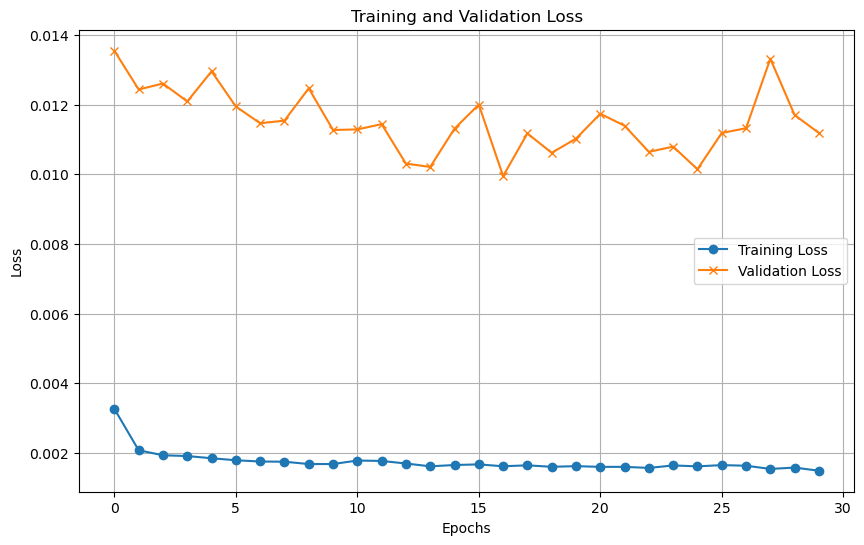

In [90]:
import matplotlib.pyplot as plt

# 위에 제시된 훈련 및 검증 과정 코드 실행 후 실행

# 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
plt.plot(val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
plt.title('Training and Validation Loss')  # 그래프 제목
plt.xlabel('Epochs')  # x축 라벨
plt.ylabel('Loss')  # y축 라벨
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 보여주기

In [104]:
# 테스트 데이터셋에 대한 평가 및 결과 출력

model.eval()  # 모델을 평가 모드로 설정
test_losses = []  # 테스트 손실을 저장할 리스트
predictions = []  # 예측값을 저장할 리스트
actuals = []  # 실제값을 저장할 리스트

with torch.no_grad():  # 기울기 계산을 비활성화
    for seqs, labels in test_loader:

        outputs = model(seqs)

        # 손실 계산
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # 예측값과 실제값 저장
        predictions.extend(outputs.view(-1).detach().numpy())
        actuals.extend(labels.view(-1).detach().numpy())

# 평균 테스트 손실 계산 및 출력
average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss}')

c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.03244742059503259


In [127]:
predictions_temp = np.zeros((len(predictions), 5))  # 5는 특성의 총 개수입니다.
predictions_temp[:, 4] = predictions  # 종가 위치에 예측값 할당

actuals_temp = np.zeros((len(actuals), 5))  # 실제 데이터를 위한 동일한 접근 방식
actuals_temp[:, 4] = actuals  # 종가 위치에 실제값 할당

# 예측값과 실제값 출력 (처음 10개 샘플)
yest=np.delete(np.insert(scaler.inverse_transform(X_test[:,-1,:])[:,-1], 0, 0), -1)
predictions_inverse = np.round(scaler.inverse_transform(predictions_temp)[:,4], -2)+yest
actuals_inverse = np.round(scaler.inverse_transform(actuals_temp)[:,4], -2)+yest

# 역정규화된 예측값과 실제값 출력 (처음 10개 샘플)
print("Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):")
for i in range(10):
    print(f'Prediction: {predictions_inverse[i]:.4f}, Actual: {actuals_inverse[i]:.4f}')

Predictions vs. Actuals (First 10 Samples, After Inverse Scaling):
Prediction: 70800.0000, Actual: 74100.0000
Prediction: 145200.0000, Actual: 148500.0000
Prediction: 144800.0000, Actual: 148200.0000
Prediction: 144700.0000, Actual: 148100.0000
Prediction: 144800.0000, Actual: 148000.0000
Prediction: 144800.0000, Actual: 147900.0000
Prediction: 144600.0000, Actual: 148000.0000
Prediction: 144500.0000, Actual: 147800.0000
Prediction: 144800.0000, Actual: 148300.0000
Prediction: 144700.0000, Actual: 147700.0000


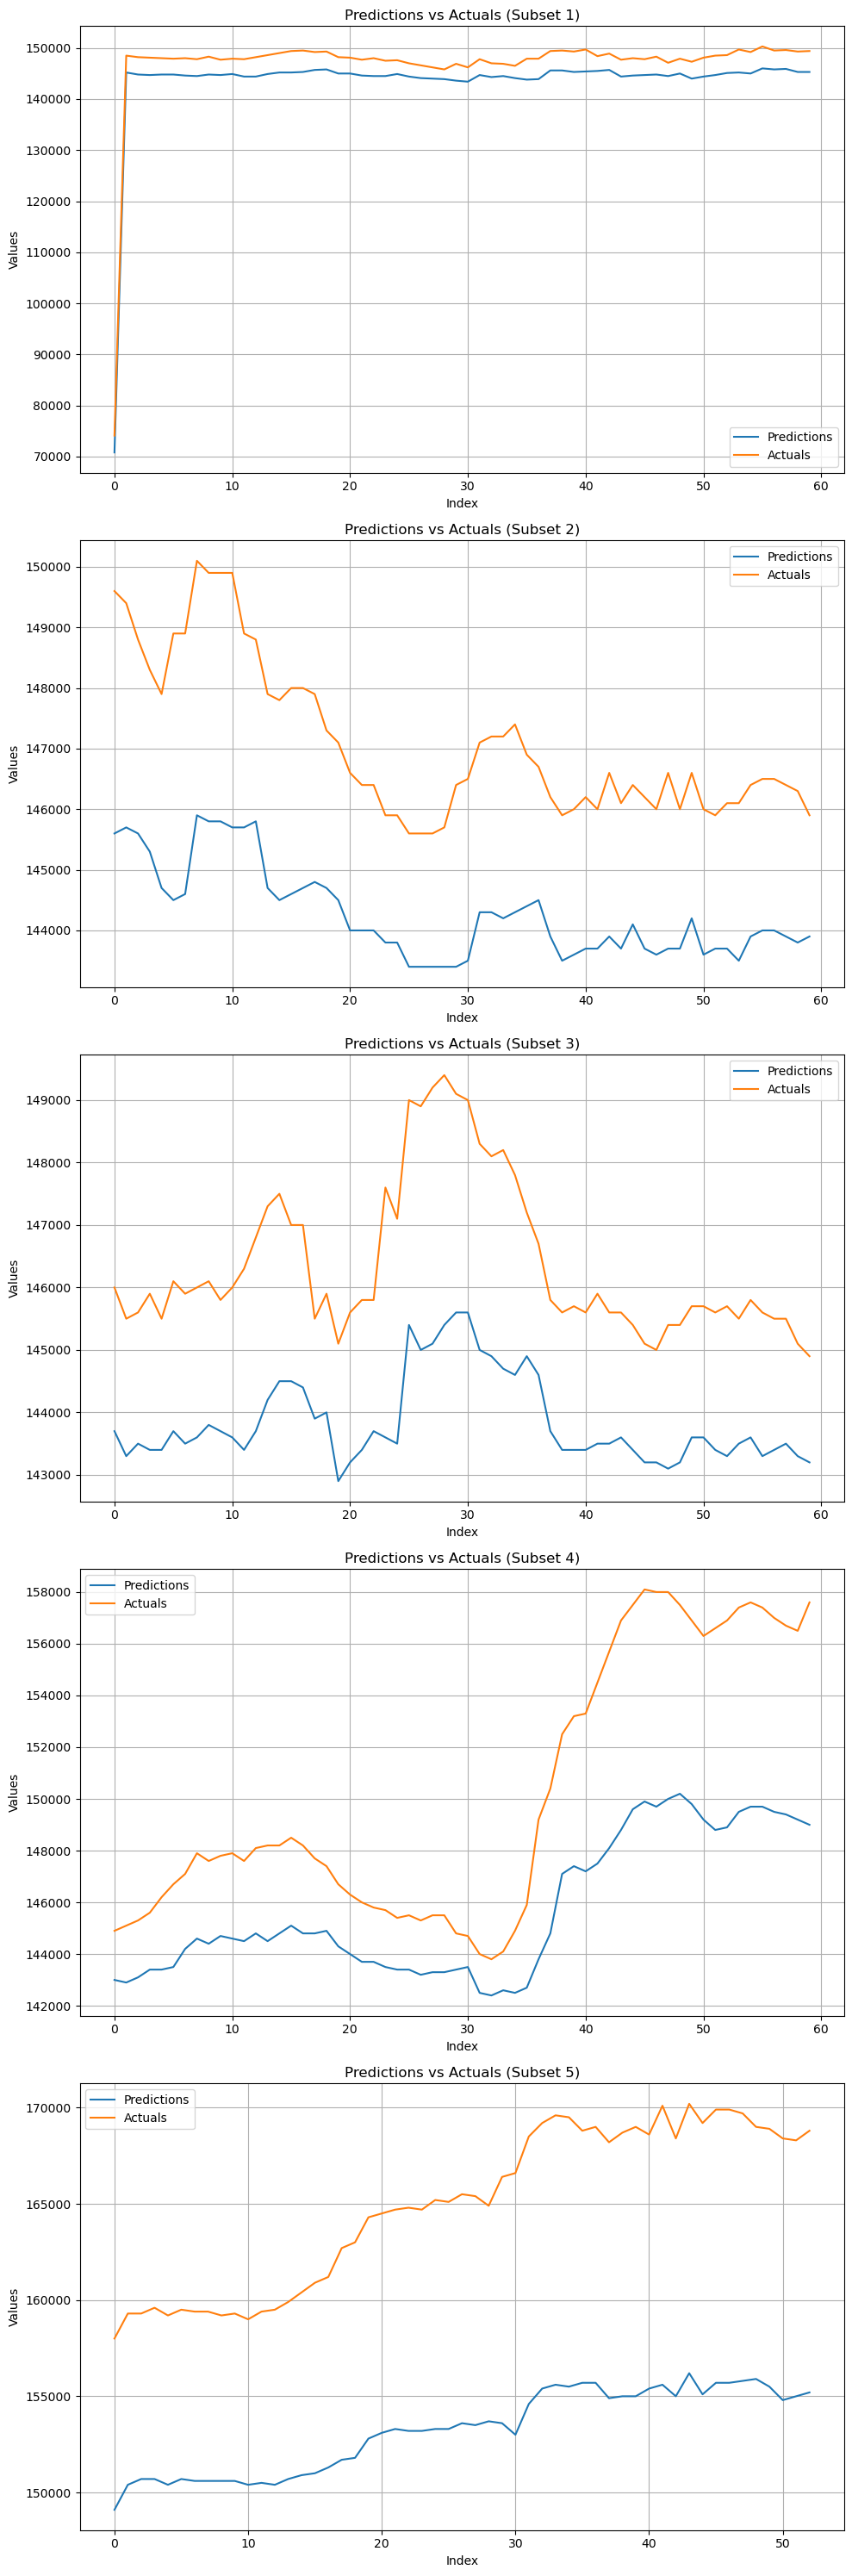

In [128]:
import matplotlib.pyplot as plt

# 전체 데이터를 4개로 나누기
n = 60
num_plots = len(predictions_inverse) // n
if len(predictions_inverse) % n != 0:
    num_plots += 1

# Plot 생성
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

for i in range(num_plots):
    start_index = i * n
    end_index = min((i + 1) * n, len(predictions_inverse))
    
    # Subplot 생성
    ax = axes[i] if num_plots > 1 else axes
    
    # 예측값과 실제값 그리기
    ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
    ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
    ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()